From https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/PyTorch%20Deep%20Explainer%20MNIST%20example.html

In [1]:
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F

import numpy as np
import shap

In [2]:
batch_size = 128
device = torch.device('cpu')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.log(), target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [3]:
num_epochs = 1 
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.320952
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.247802
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.582416
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.070415
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.918220

Test set: Average loss: 0.0051, Accuracy: 8792/10000 (88%)



In [4]:
batch = next(iter(test_loader))
images, target = batch

datad, targetd = images.to(device), target.to(device)
output = model(datad)
pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
#print(output[:101])
#print(pred[:101])

background = images[:100]
test_images = images[100:]

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [5]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

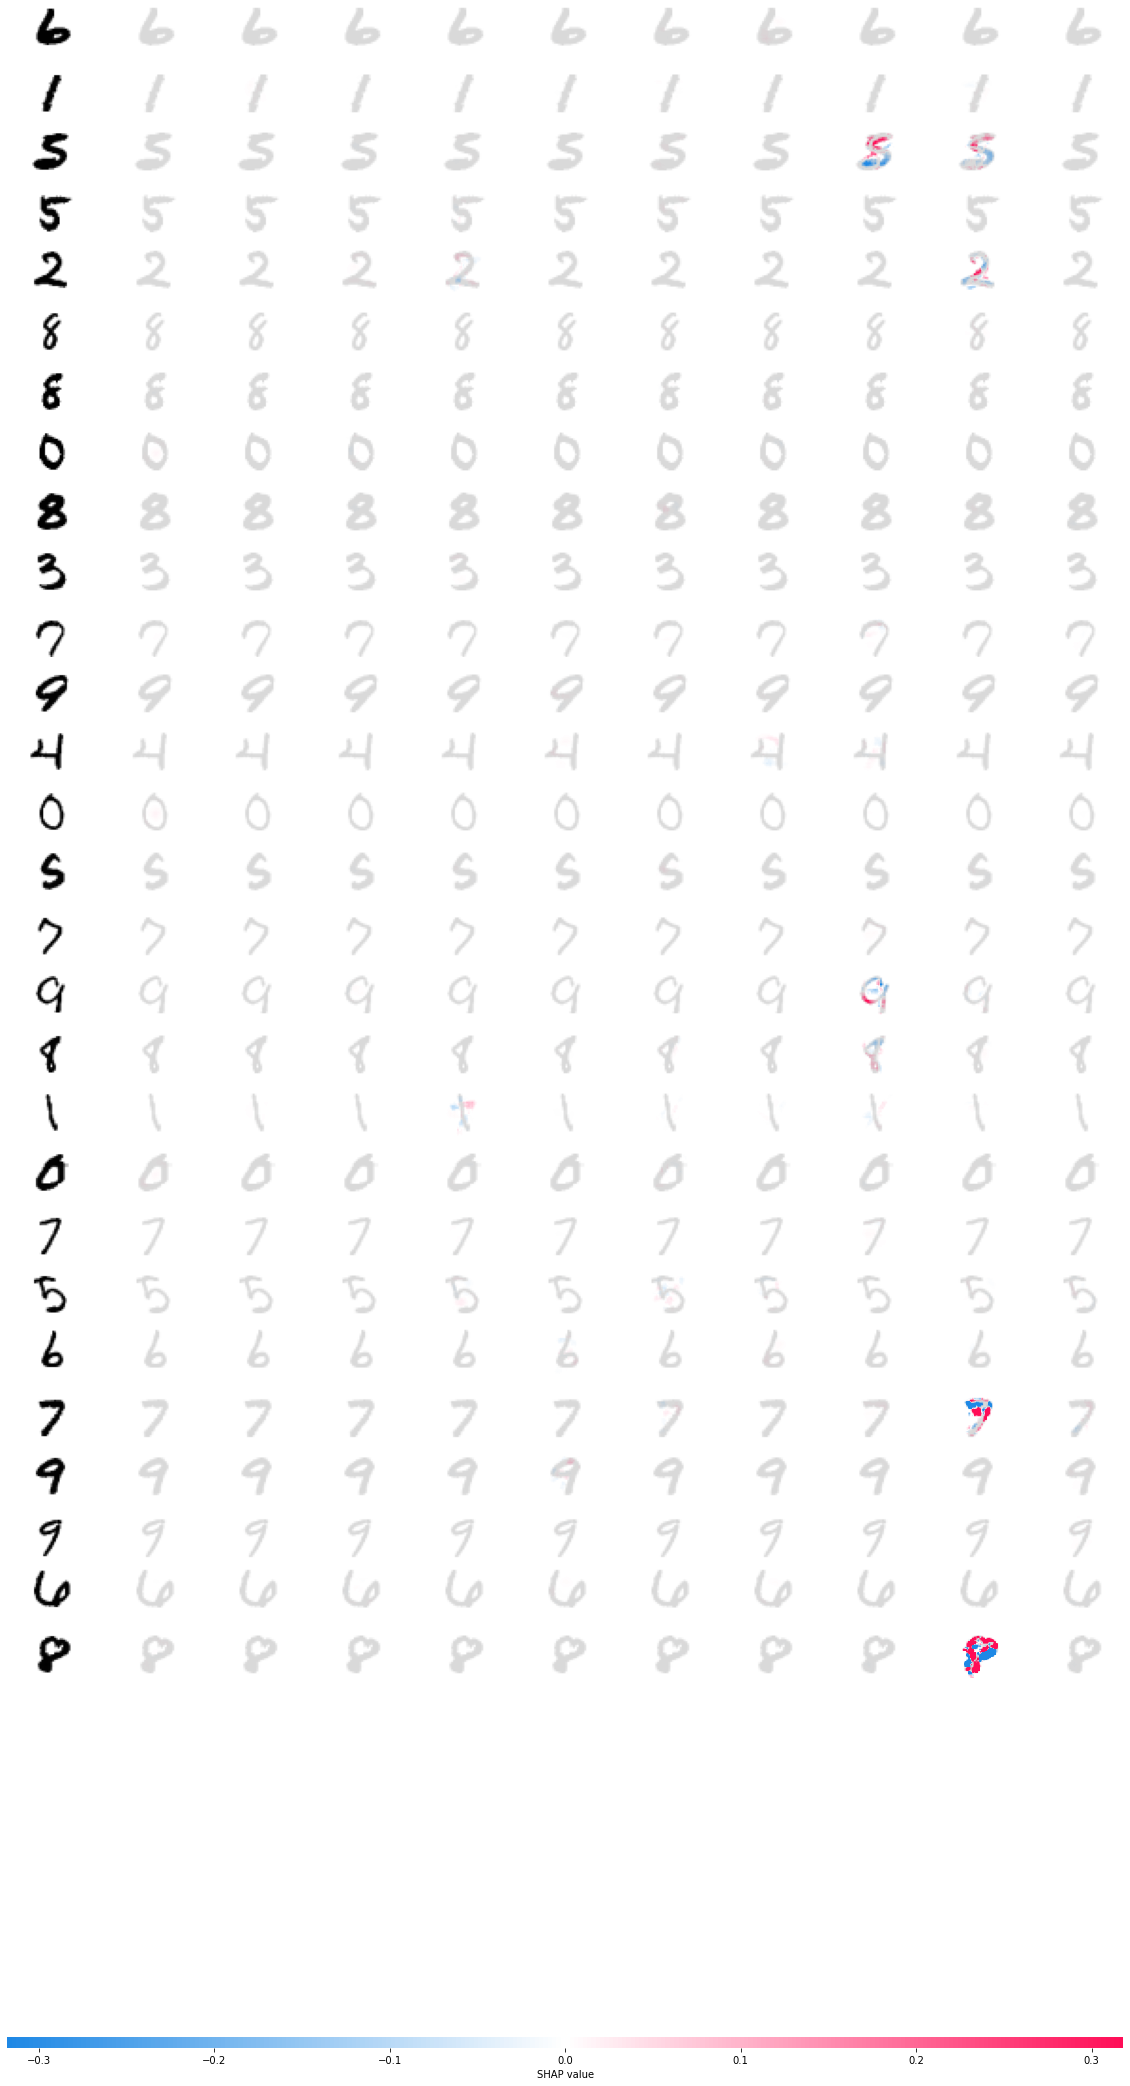

In [6]:
# plot the feature attributions
shap.image_plot(shap_numpy, -test_numpy)

# Tests

In [12]:
batch = next(iter(test_loader))
images, target = batch

datad, targetd = images.to(device), target.to(device)
output = model(datad)
pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
#print(output[:101])
#print(pred[:101])

BACKGROUND_SIZE = 100

background = images[:BACKGROUND_SIZE]
test_images = images[BACKGROUND_SIZE:]

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

In [13]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

Predicted 0
Actual 0
[9.5725024e-01 5.7219248e-05 1.8200241e-02 2.3423417e-03 3.8957133e-04
 1.3190816e-02 1.5030754e-03 2.7810861e-03 3.2406913e-03 1.0447560e-03]


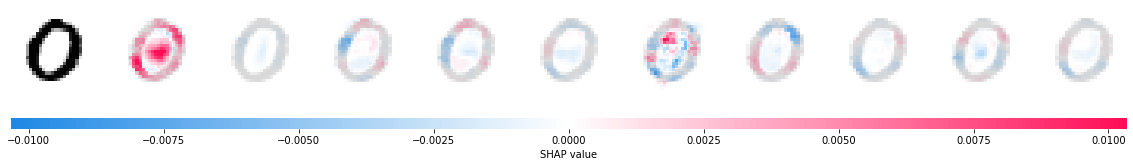

Predicted 0
Actual 0
[8.9591932e-01 2.8402908e-04 1.2404089e-02 2.9613562e-03 7.4580766e-04
 6.2673621e-02 8.5145934e-03 2.3240449e-03 1.2461529e-02 1.7116481e-03]


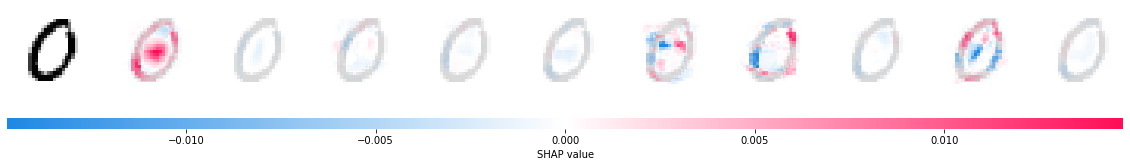

Predicted 3
Actual 3
[0.02344737 0.01259207 0.06534471 0.61981106 0.00968237 0.14515086
 0.01647725 0.023442   0.06271214 0.0213402 ]


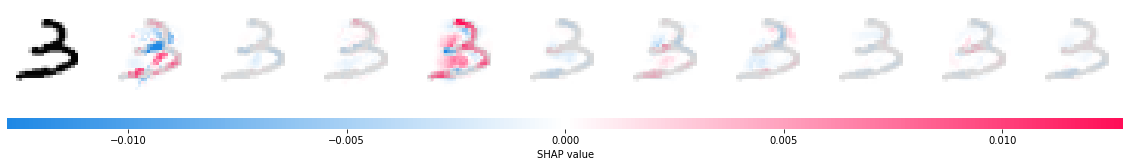

Predicted 6
Actual 6
[0.04472378 0.04080113 0.09231582 0.02587964 0.08761743 0.10599889
 0.47930193 0.01336465 0.08143745 0.02855934]


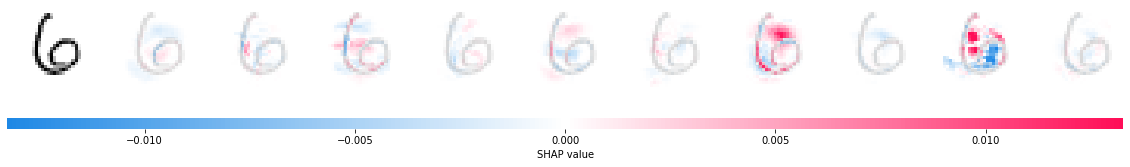

Predicted 2
Actual 2
[0.0048693  0.0060248  0.74324244 0.01892677 0.03817598 0.01437155
 0.151254   0.00217173 0.01439845 0.00656496]


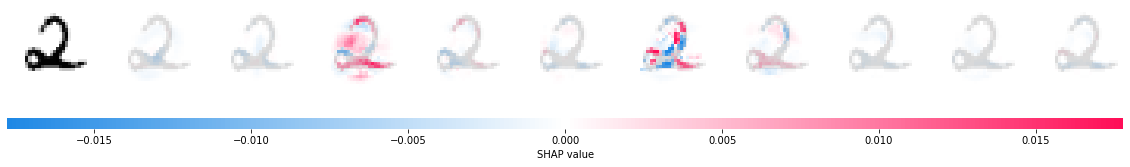

Predicted 5
Actual 5
[0.01836997 0.00164112 0.04918459 0.06709871 0.01157126 0.56908643
 0.19148545 0.00101561 0.0838629  0.00668386]


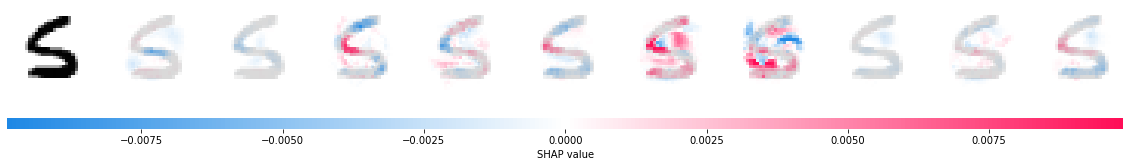

Predicted 3
Actual 3
[0.00386352 0.00982169 0.04150639 0.74086326 0.00329731 0.09815423
 0.00273005 0.01717531 0.07015783 0.01243027]


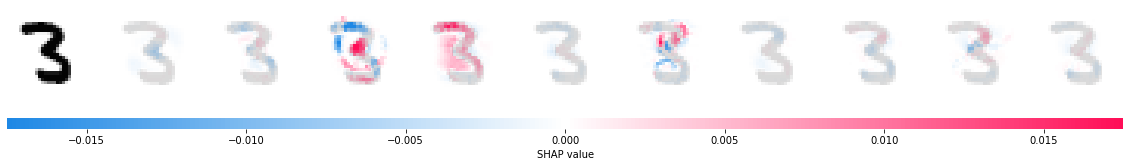

Predicted 3
Actual 3
[0.00482457 0.00215081 0.04070069 0.8123227  0.00105443 0.07444526
 0.00088274 0.02043286 0.03679252 0.00639326]


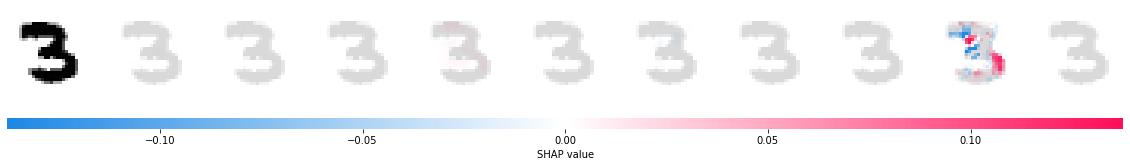

Predicted 3
Actual 3
[0.03800552 0.05039617 0.05578248 0.32084382 0.00720893 0.2769532
 0.03455937 0.02983588 0.16393709 0.02247758]


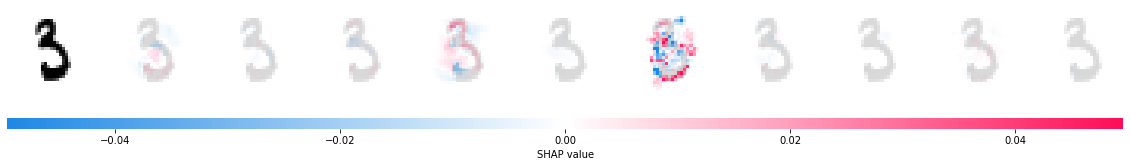

Predicted 8
Actual 8
[0.01319608 0.00642649 0.02164221 0.0449577  0.02012561 0.3543436
 0.05045459 0.00339081 0.468691   0.01677197]


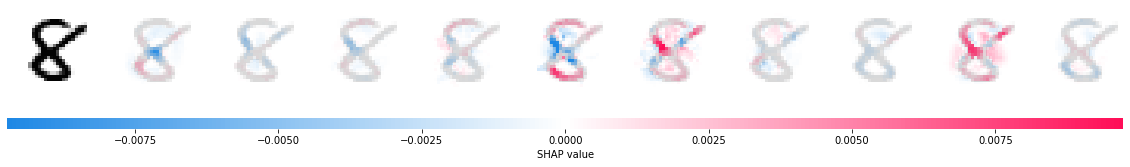

Predicted 5
Actual 5
[0.05891427 0.0564474  0.05064086 0.08298471 0.06725263 0.305953
 0.09042151 0.04942912 0.15452017 0.08343625]


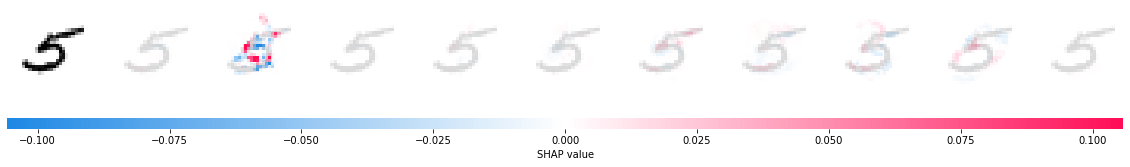

Predicted 5
Actual 5
[2.5269771e-02 4.9979496e-04 4.8111337e-03 1.0717895e-02 1.3275093e-02
 7.3610276e-01 1.3677971e-02 3.2210739e-03 1.7391947e-01 1.8505033e-02]


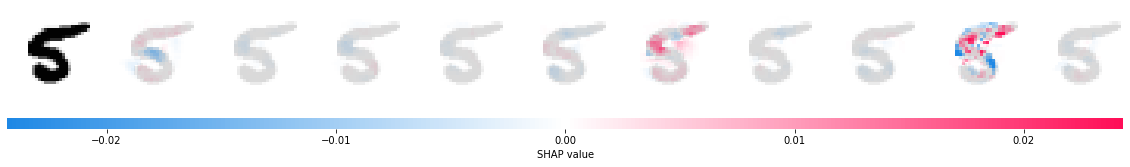

Predicted 8
Actual 8
[0.00957807 0.01066998 0.03006941 0.04467853 0.11394396 0.2571184
 0.08958984 0.00917374 0.3568968  0.07828122]


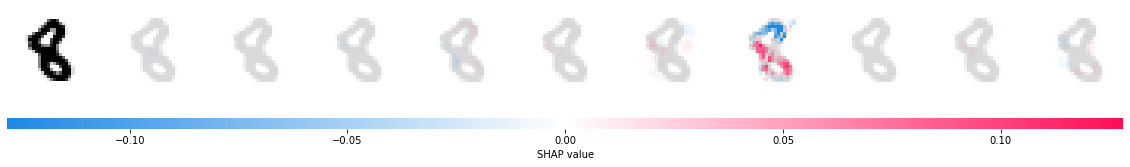

Predicted 3
Actual 3
[0.00677469 0.01896572 0.05652528 0.4115192  0.05593707 0.14320855
 0.01428816 0.03990404 0.12639195 0.12648539]


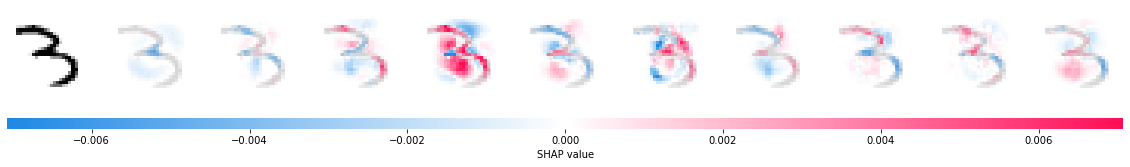

Predicted 5
Actual 5
[0.02941765 0.00080489 0.00615952 0.00850726 0.00080701 0.7933394
 0.00666569 0.00157227 0.15055116 0.0021751 ]


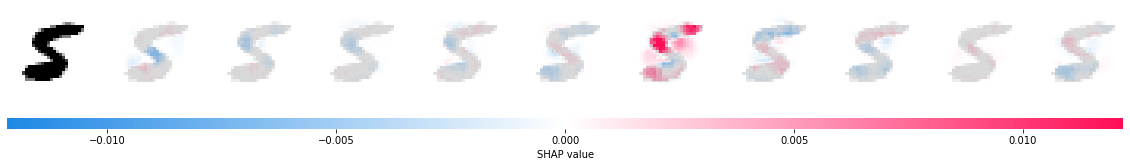

Predicted 5
Actual 5
[0.00439906 0.00075405 0.00972603 0.08961897 0.01475332 0.6481581
 0.006377   0.00285296 0.19733274 0.02602782]


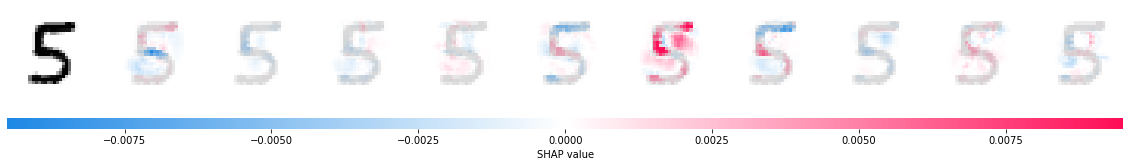

Predicted 8
Actual 8
[0.01641214 0.06484349 0.02264142 0.05540875 0.00668949 0.21589209
 0.01111329 0.03549817 0.5374612  0.03403995]


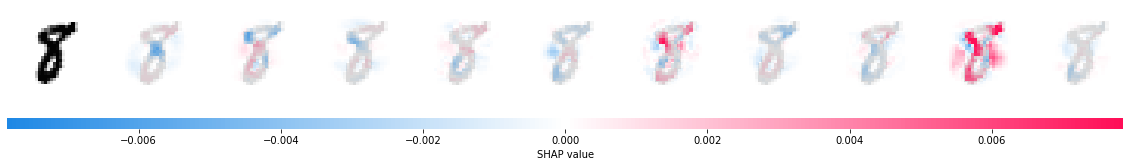

Predicted 6
Actual 6
[0.05712063 0.02464751 0.08490697 0.0119776  0.05352156 0.08510908
 0.60588425 0.00731269 0.05466665 0.01485301]


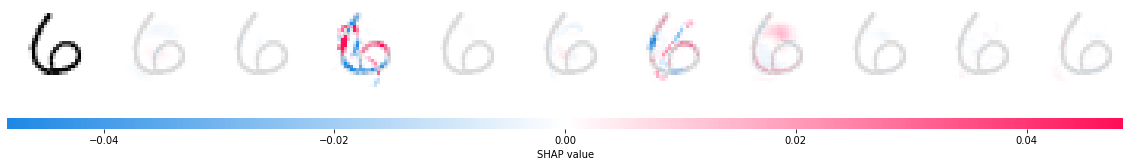

Predicted 0
Actual 0
[0.5870918  0.00586329 0.04967034 0.04439684 0.01116544 0.11638188
 0.02283183 0.05872533 0.06386608 0.04000717]


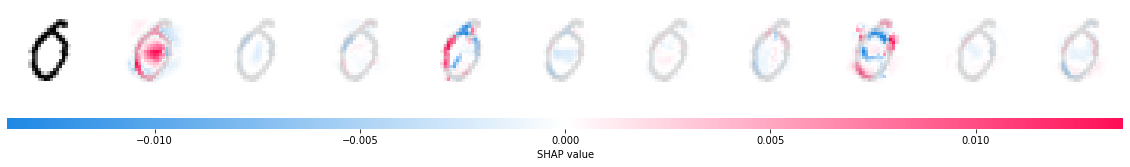

Predicted 9
Actual 9
[0.0017773  0.00199932 0.0140243  0.03706772 0.2963398  0.04494416
 0.00499521 0.05896512 0.0633347  0.47655234]


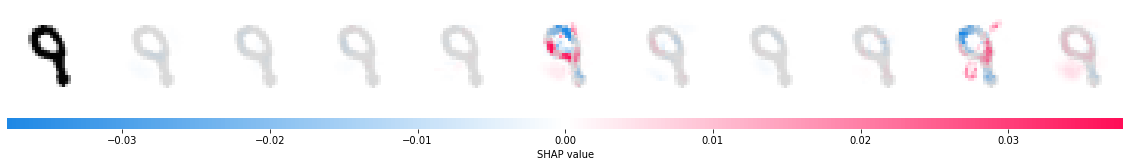

Predicted 2
Actual 2
[5.2617821e-03 4.1069100e-03 8.9976728e-01 7.5129054e-02 7.1687647e-04
 3.2100244e-03 3.2479747e-03 3.3227096e-03 4.6263030e-03 6.1105733e-04]


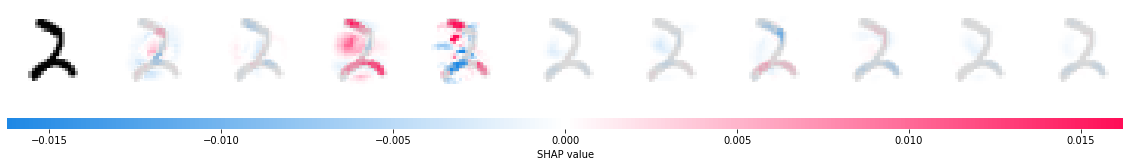

Predicted 1
Actual 1
[0.0249042  0.41711706 0.06145576 0.10220201 0.02763622 0.0626234
 0.0254173  0.08536784 0.13483314 0.05844299]


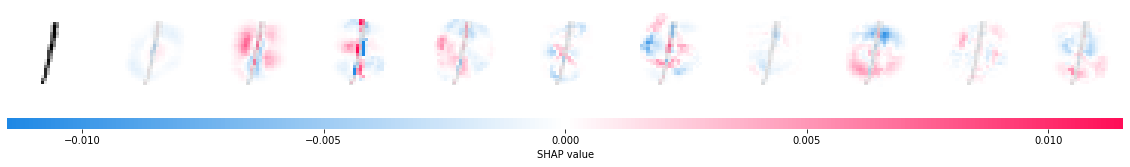

Predicted 9
Actual 9
[0.00397825 0.01248592 0.01523378 0.13056241 0.11638719 0.06786964
 0.00510713 0.1407655  0.11332782 0.3942823 ]


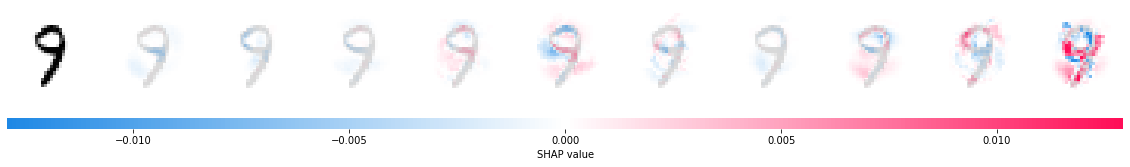

Predicted 5
Actual 5
[0.02451002 0.08033048 0.03770649 0.06134359 0.05184751 0.32219145
 0.05702849 0.03140465 0.27579543 0.05784193]


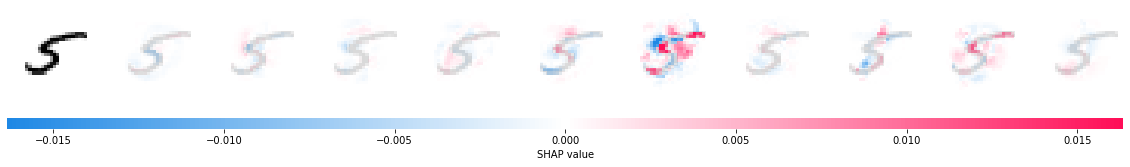

Predicted 2
Actual 2
[0.03998608 0.0047437  0.6240764  0.17797105 0.01753021 0.02462162
 0.01333325 0.0309158  0.0427877  0.02403413]


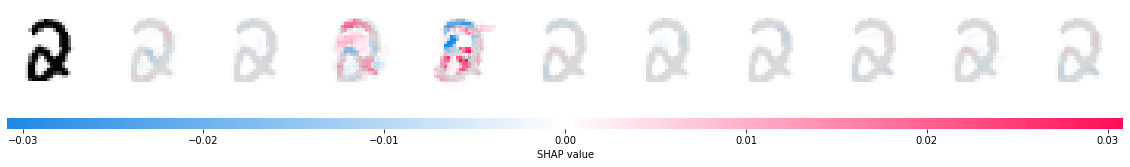

Predicted 0
Actual 0
[9.6247470e-01 5.9363105e-05 8.1936289e-03 2.3549718e-03 7.6952449e-05
 2.0546488e-02 1.0145763e-03 1.9446962e-03 2.9123412e-03 4.2235266e-04]


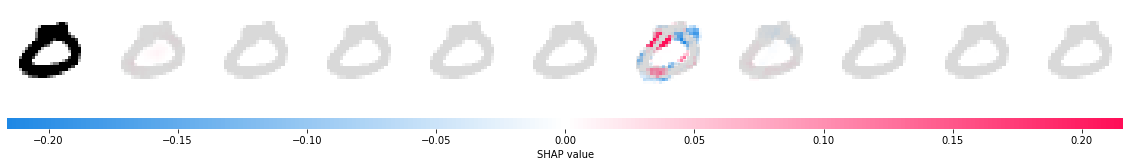

Predicted 9
Actual 4
[0.00295693 0.00834493 0.0188154  0.03168826 0.37864283 0.03376371
 0.00955587 0.05504263 0.03748067 0.42370877]


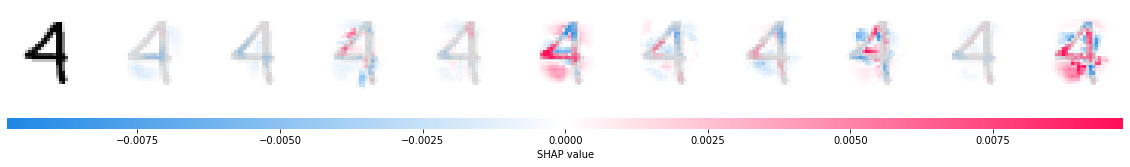

Predicted 9
Actual 9
[0.0043878  0.00247589 0.00543714 0.01479049 0.21535979 0.02593239
 0.00325328 0.12353811 0.03949382 0.56533134]


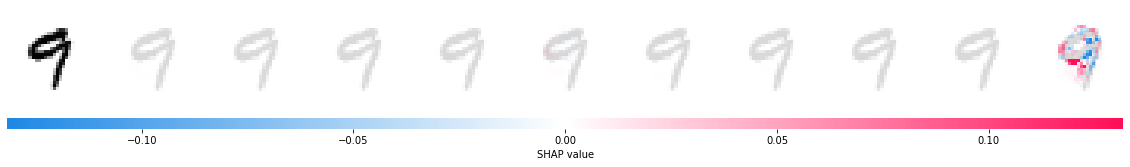

In [15]:
for i in range(0,len(test_numpy)):
    test_index = BACKGROUND_SIZE + i
    print('Predicted', pred.numpy()[test_index][0])
    print('Actual', target.numpy()[test_index])
    print(output[test_index].detach().numpy())

    ti = test_images[[i]]
    sv = e.shap_values(ti)
    sn = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in sv]
    tn = np.swapaxes(np.swapaxes(ti.numpy(), 1, -1), 1, 2)
    shap.image_plot(sn, -tn)


Figure(1440x3163.64)
309


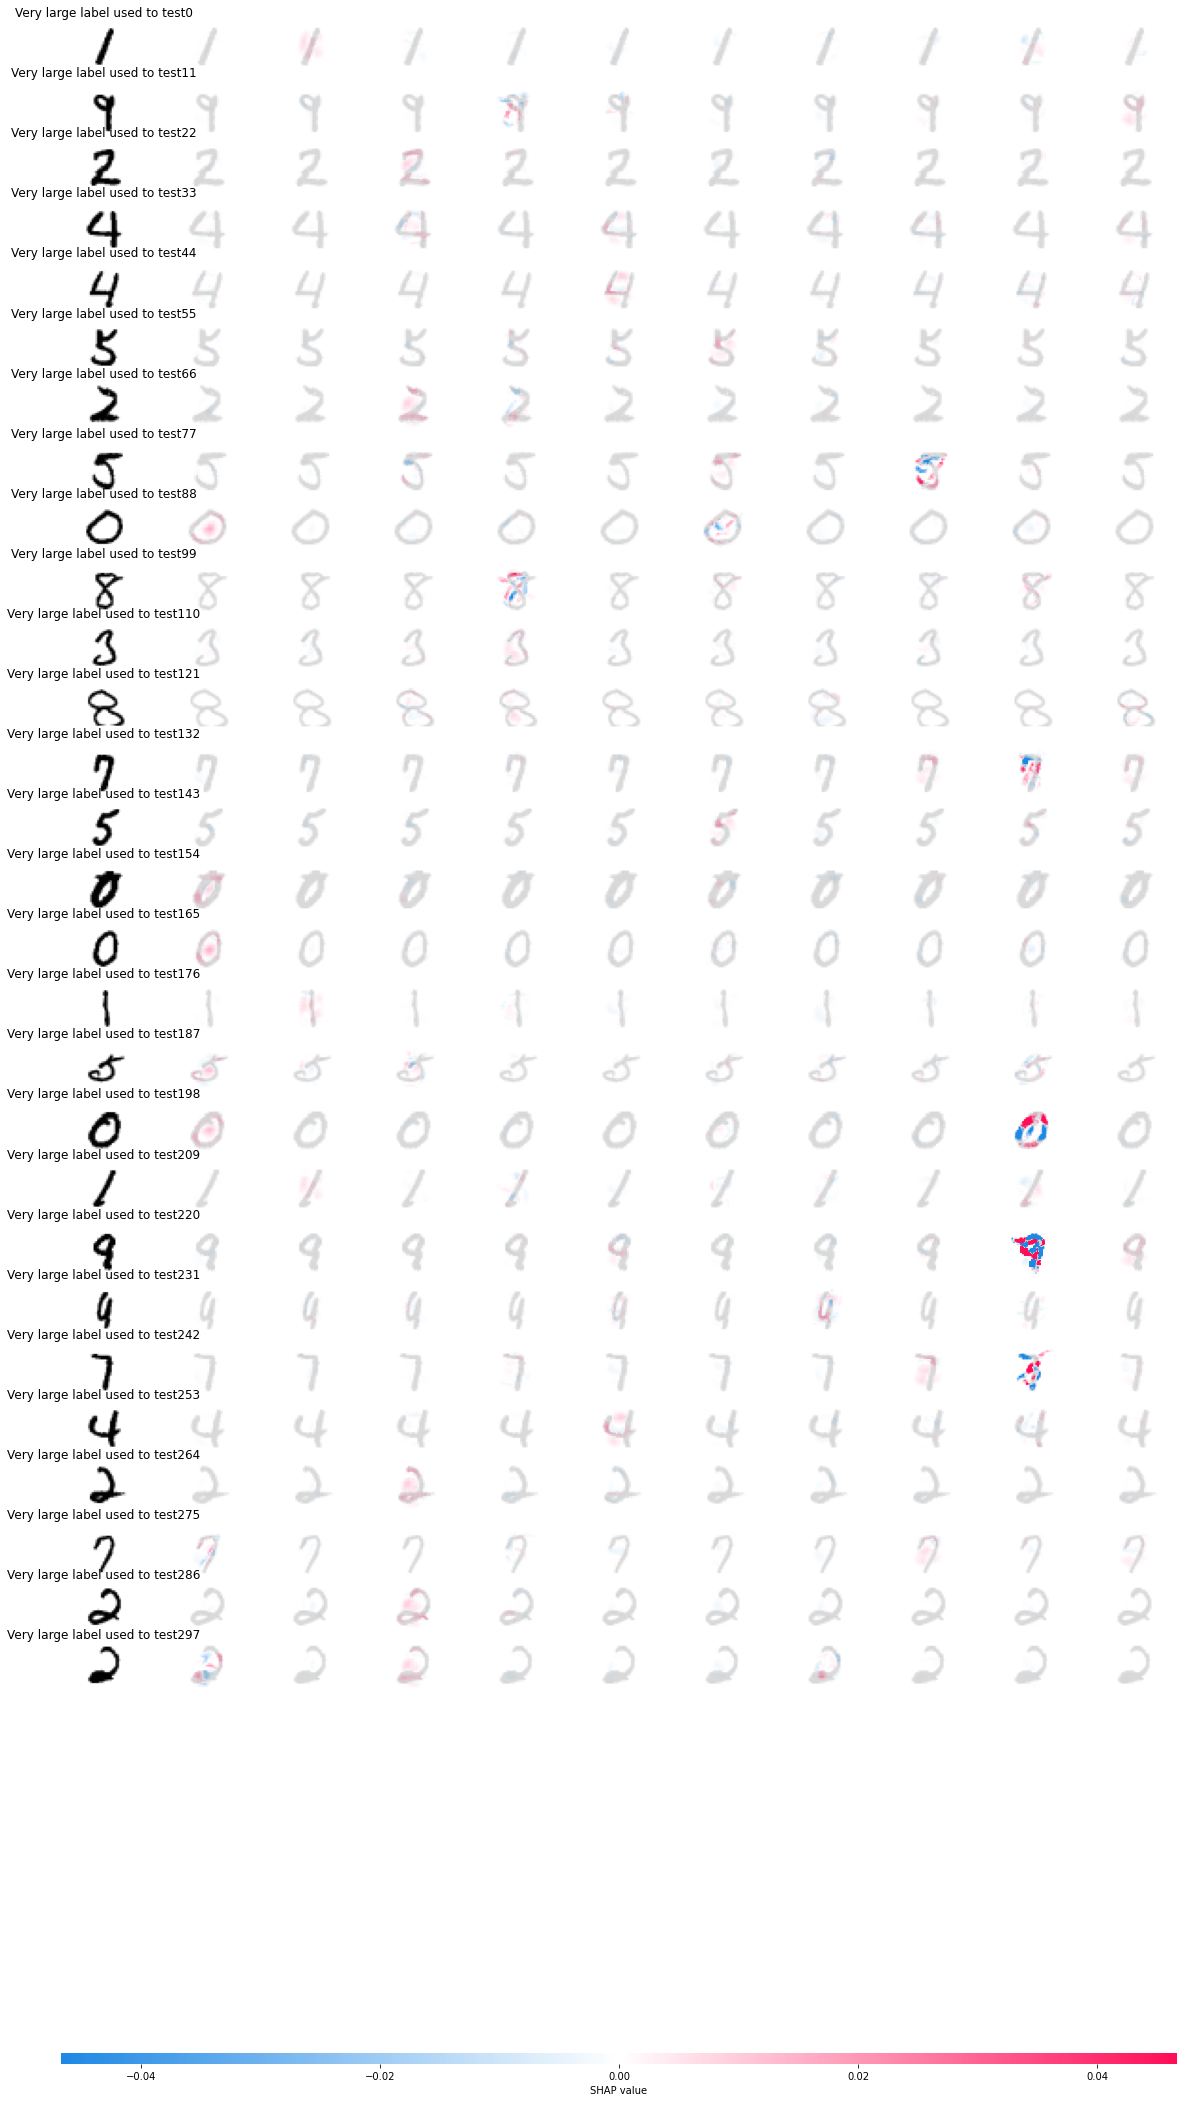

In [10]:
# plot the feature attributions
import matplotlib.pyplot as plt

shap.image_plot(shap_numpy, -test_numpy, show=False)
fig = plt.gcf()
allaxes = fig.get_axes()
print(fig)
print(len(allaxes))

# There are 11 axes for each picture: 1 for the digit + 10 for each SHAP
# There is a last axis for the scale - we don't want to apply a label for that tone
for x in range(0,len(allaxes)-1, 11):
    allaxes[x].set_title('Very large label used to test{}'.format(x))
